# Tutorial for CuNA 

CuNA has two parts to it: 
1. computing redescription groups by cumulants and 
2. performing network analysis after forming a network from the redescription groups.

In [1]:
%cd "/home/abose/Geno4SD/"
import pandas as pd 
import numpy as np 
import os, sys, time, random, math
from geno4sd.topology.CuNA import cumulants, cuna, cures

import matplotlib.pyplot as plt
import seaborn as sns
#warnings.filterwarnings('ignore')


/home/abose/Geno4SD


### Read data
We use a sample data from TCGA Breast cancer study. We have selected a subset of mRNAs, miRNAs and proteins which are associated with breast cancer in this data. 

In [12]:
path = '/home/abose/Geno4SD/docs/data/'
df = pd.read_csv(path+'tcga_mixomics_new_train_forcuna.csv')
df.index=df['ID']
df.drop(['ID'], axis=1, inplace=True)

target = pd.read_csv(path+'tcga_subtypes_train.csv')
y = target['x'].map({'Basal':1, 'Her2':2, 'LumA': 3})

assert df.shape[0] == len(y)
print('X and y dimensions match!\n')

print("Number of individuals: ", df.shape[0])
print("Number of features: ", df.shape[1])
print("\nNumber of each subtype: ", target.groupby('x').size())

X and y dimensions match!

Number of individuals:  180
Number of features:  43

Number of each subtype:  x
Basal    54
Her2     35
LumA     91
dtype: int64


In [19]:
df.head()

,ZNF552,KDM4B,CCNA2,LRIG1,PREX1,FUT8,C4orf34,TTC39A,ASPM,SLC43A3,...,hsa-mir-146a,ER-alpha,GATA3,ASNS,Cyclin_B1,AR,Cyclin_E1,JNK2,PR,INPP4B
ID,,,,,,,,,,,,,,,,,,,,,
A0FJ,3.310659,6.549551,5.332618,6.754879,4.469941,2.657454,4.038446,2.581035,6.028050,7.746416,...,8.036462,-3.735720,-1.936132,0.811463,1.516735,-1.307606,0.987851,-0.567644,-0.780103,-0.325678
A13E,2.453071,5.862749,5.833160,6.360029,4.047861,2.455102,5.080940,5.062327,6.286401,7.177938,...,7.558073,-1.819547,-2.279977,1.181016,1.025777,-1.620476,0.249590,-0.668122,-0.384844,-0.381475
A0G0,3.723843,5.954117,5.595054,6.214211,4.438450,5.329553,5.569353,4.360152,7.289928,7.389874,...,7.455402,-3.873648,-1.581067,1.950922,0.977360,-1.077894,-0.329459,-0.540845,-1.166537,-0.518444
A0SX,3.471480,6.462346,5.416599,6.187161,6.212043,4.976205,4.698853,6.163528,6.577661,7.340998,...,8.535928,-2.998116,-1.572635,0.607424,0.569273,-1.267055,1.425507,-0.173740,-0.259154,0.464042
A143,3.945742,5.678434,5.316069,7.975104,5.102479,6.372000,5.181146,4.193572,6.527630,6.451219,...,6.356079,-4.189787,-1.847252,0.538763,1.368957,-0.601327,1.406639,-0.103767,-1.347701,-0.908022


## Computing Cumulants

<blockquote>
&nbsp;

Pre-requisites if using Julia Cumulants i.e. `julia = 1`:

1. Install Julia to your environment:

    - wget https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.2-linux-x86_64.tar.gz

    - tar zxvf julia-1.9.2-linux-x86_64.tar.gz

2. Export path to Julia:

    - export PATH = "$PATH:/data/shared/user/julia-1.9.2/bin"
    - alternatively set flag in cumulants.get_cumulants(): julia_path = "/path/to/Julia/julia-1.9.2/bin/julia"
    
3. Launch Julia and install packages for computing cumulants:
    ```julia
    using Pkg
    Pkg.add.(["Cumulants", "NPZ", "LinearAlgebra", "Random", "Statistics"])
    ```
&nbsp;
</blockquote>

In [3]:
beg_time = time.time()
cumulants_df, vec_df = cumulants.get_cumulants(df, verbose = 1, julia = 1, julia_path = "", order = 3)
print("Time spent computing cumulants (mins): ", (time.time() - beg_time)/60)

Time spent computing cumulants (mins):  0.6619281808535258


### Filter significant cumulants 

In [4]:
filt_cumulants_df = cumulants_df[cumulants_df['P'] < 0.05]  
filt_vec_df = vec_df[vec_df.k.isin(list(filt_cumulants_df.index))]
print("Number of significant redescription groups: ", filt_vec_df.shape[0])

Number of significant redescription groups:  46040


#### print cumulant statistics

In [5]:
print("Cumulant statistics \n")
print(filt_cumulants_df.sample(n=4))
print("\n ------------\n")
print("Cumulant vectors\n")
print(filt_vec_df.sample(n=4))

Cumulant statistics 

                                           k_res      Mean    StdDev  \
index                                                                  
KDM4B&LMO4&MED13L&hsa-let-7d           -0.174156 -0.015231  0.064661   
LMO4&CSRP2&hsa-mir-130b&hsa-mir-1301   -0.167287  0.026801  0.088832   
LRIG1&SLC43A3&hsa-mir-505&hsa-mir-146a  0.271210  0.004263  0.084926   
STC2&FMNL2&hsa-mir-17&hsa-mir-20a       0.343092  0.026616  0.061649   

                                               Z             P  
index                                                           
KDM4B&LMO4&MED13L&hsa-let-7d           -2.457837  1.397764e-02  
LMO4&CSRP2&hsa-mir-130b&hsa-mir-1301   -2.184880  2.889763e-02  
LRIG1&SLC43A3&hsa-mir-505&hsa-mir-146a  3.143302  1.670537e-03  
STC2&FMNL2&hsa-mir-17&hsa-mir-20a       5.133501  2.844009e-07  

 ------------

Cumulant vectors

                                       k         0         1         2  \
14552      KDM4B&C4orf34&E2F1&hsa-mir-93 -0.671

## CuRES

In [6]:
beg_time = time.time()

cures_vec, res, assoc = cures.get_cures(filt_vec_df.set_index('k').T, 
                                        y, 
                                        verbose=1,               
                                        fit_cures=False,
                                        multi_class=True)

print("Time spent computing cures (mins): ", (time.time() - beg_time)/60)


Best performing logistic regression model on training data:  {'C': 1.0, 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
-------------------------------------
Model fitting complete
-------------------------------------
F1 score of fitted model on test data:  0.8221119929453263
-------------------------------------

**************************************
Computing CuReS
**************************************
Time spent computing cures (mins):  0.49988062779108683


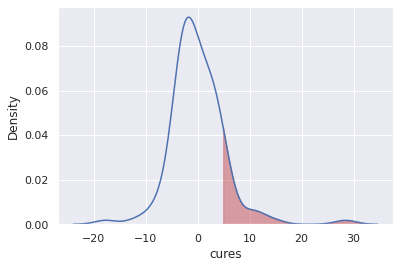

In [7]:
cures_vec_ = [x for sublist in list(cures_vec) for x in sublist]
cures_df = pd.DataFrame()
cures_df['cures'] = cures_vec_
cures_df['decile'] = pd.qcut(cures_df['cures'], 10, labels=False, duplicates='drop')

thres_decile = 9
nth_decile = np.min(cures_df[cures_df['decile'] >= thres_decile]['cures'])

fig = plt.figure(figsize=(6,4))
points = sns.kdeplot(data = cures_df, 
                     x='cures',
                     shade= False).get_lines()[0].get_data()

x1 = points[0]
y1 = points[1]

plt.fill_between(x1,y1, where = x1 > nth_decile, color='r', alpha=0.5)

In [31]:
fig.savefig("/home/abose/PD/new/Data/CuReSplot_mockdata_pheno0.png",
               dpi=600, bbox_inches='tight')

In [7]:
cumulants_df.to_csv('test.csv', index=False)

#### The p-value input should be a list of p-values. 

### Computing CuNA (Cumulant-based network analysis)
CuNA returns the following:
    1. A dataframe with edges in its rows and the connected vertices in columns along with the statistical significance (measured by p-value) from the Fisher Exact test. 
    2. **count** or weight of the edge. 
    3. A dataframe of varying row lengths (contains None for empty fields) with the community membership information for all the vertices. 
    4. A dataframe with node rank. A score indicating the importance of each vertex across different centrality measures. The lower the score means higher the importance. 

In [9]:
beg_time = time.time()
p = [1e-2, 1e-5, 1e-8]
interactions, nodes, communities, noderank = cuna.get_network(cumulants_df.copy(),
                                                              0, 
                                                              p, 
                                                              verbose=0)
print("Time spent computing CuNA network (mins): ", (time.time() - beg_time)/60)

In [13]:
tcga_network = pd.read_excel(path+"CuNA_network_tcga_breastcancer.xlsx")
tcga_network.head()

,v1,v2,pval,count
0,Cyclin_E1,hsa-mir-532,5.490000e-27,66
1,SLC43A3,ASNS,9.760000e-22,6
2,SLC43A3,CCNA2,1.460000e-19,7
3,TTC39A,hsa-mir-532,5.420000e-15,6
4,MED13L,hsa-mir-532,1.070000e-13,4


### Communities in the network

In [14]:
tcga_communities = pd.read_csv(path+"tcga_communities.csv")
tcga_communities

,Community0,MEX3A,hsa-mir-106b,LRIG1,JNK2,KDM4B,TTC39A,ER-alpha,hsa-mir-505,Cyclin_B1,hsa-mir-130b,hsa-let-7d,hsa-mir-106a
0,Community1,hsa-mir-590,ZNF552,hsa-mir-93,MED13L,NTN4,STC2,C4orf34,E2F1,hsa-mir-186,ASPM,GATA3,hsa-mir-532
1,Community2,SLC43A3,AR,ASNS,hsa-mir-146a,FUT8,PREX1,SEMA3C,hsa-mir-20a,CCNA2,DTWD2,NaN,NaN
2,Community3,Cyclin_E1,FMNL2,hsa-mir-17,INPP4B,CSRP2,PR,LMO4,hsa-mir-1301,hsa-mir-197,NaN,NaN,NaN


### Top 10 ranked nodes in the network

In [16]:
toprank_df = pd.read_csv(path+"TCGA_Rank_score_nodes.txt", sep="\t")
toprank_df[:10]

,Node,Score
0,NTN4,4.8
1,SLC43A3,5.0
2,STC2,6.4
3,JNK2,6.8
4,INPP4B,7.0
5,Cyclin_B1,7.4
6,hsa-mir-106b,7.8
7,ZNF552,9.6
8,hsa-mir-505,10.2
9,GATA3,11.0
